# Import Functions

In [18]:
import math, re, os
import tensorflow as tf
import numpy as np
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix
# Import all Plot function
from plot import display_training_curves, display_confusion_matrix, display_batch_of_images, CLASSES
# Imort all Image Reader function
from image_reader import get_training_dataset, get_validation_dataset, get_test_dataset, count_data_items, IMAGE_SIZE, TRAINING_FILENAMES, VALIDATION_FILENAMES, TEST_FILENAMES 
print('Tensorflow Version ' + tf.__version__)

Tensorflow Version 2.2.0


In [2]:
AUTO = tf.data.experimental.AUTOTUNE
strategy = tf.distribute.get_strategy() # default distribution strategy in Tensorflow. Works on CPU and single GPU.
EPOCHS = 12
BATCH_SIZE = 16 * strategy.num_replicas_in_sync 
#BATCH_SIZE = 16
CLASSES = CLASSES
IMAGE_SIZE = IMAGE_SIZE
TRAINING_FILENAMES = TRAINING_FILENAMES
VALIDATION_FILENAMES = VALIDATION_FILENAMES
TEST_FILENAMES = TEST_FILENAMES

# Dataset visualizations

In [3]:
print("Training data shapes:")
for image, label in get_training_dataset().take(3):
    print(image.numpy().shape, label.numpy().shape)    
print("Training data label examples:", label.numpy())

Training data shapes:
(16, 192, 192, 3) (16,)
(16, 192, 192, 3) (16,)
(16, 192, 192, 3) (16,)
Training data label examples: [55 79 13 ... 73 67 88]


In [4]:
print("Validation data shapes:")
for image, label in get_validation_dataset().take(3):
    print(image.numpy().shape, label.numpy().shape)
print("Validation data label examples:", label.numpy())

Validation data shapes:
(16, 192, 192, 3) (16,)
(16, 192, 192, 3) (16,)
(16, 192, 192, 3) (16,)
Validation data label examples: [49 43 22 ... 73  0  0]


In [5]:
print("Test data shapes:")
for image, idnum in get_test_dataset().take(3):
    print(image.numpy().shape, idnum.numpy().shape)
print("Test data IDs:", idnum.numpy().astype('U')) # U=unicode string

Test data shapes:
(16, 192, 192, 3) (16,)
(16, 192, 192, 3) (16,)
(16, 192, 192, 3) (16,)
Test data IDs: ['59d1b6146' '8d808a07b' '48c96bd6b' ... 'a98328317' 'd907ca7c0' '0b9afbdf2']


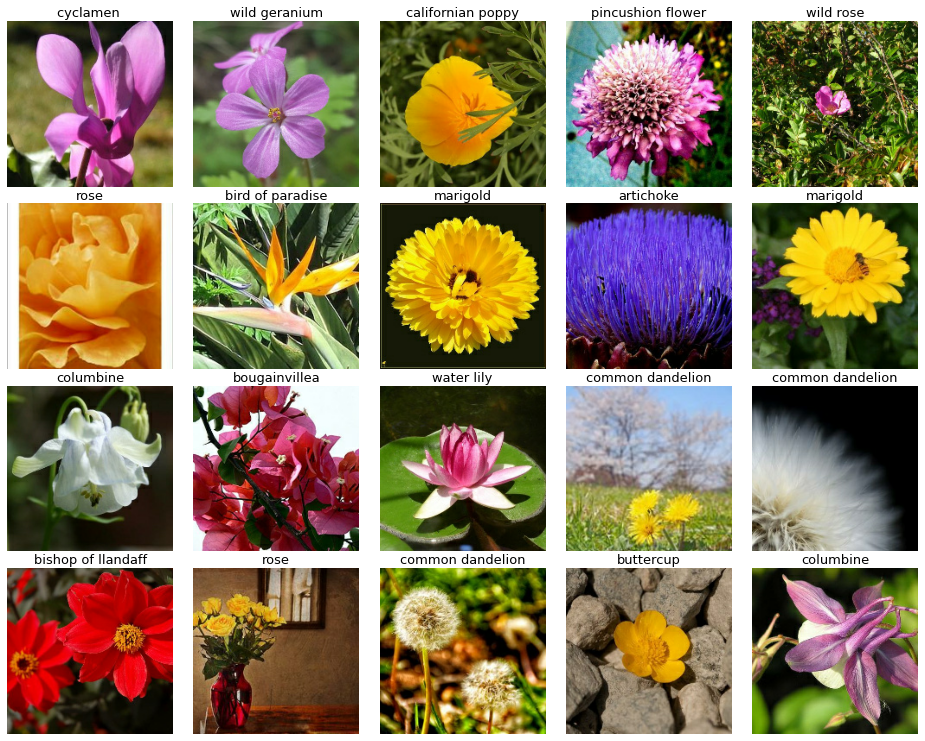

In [6]:
#Peek at training data
training_dataset = get_training_dataset()
training_dataset = training_dataset.unbatch().batch(20)
train_batch = iter(training_dataset)
#run this cell again for next set of images
display_batch_of_images(next(train_batch))

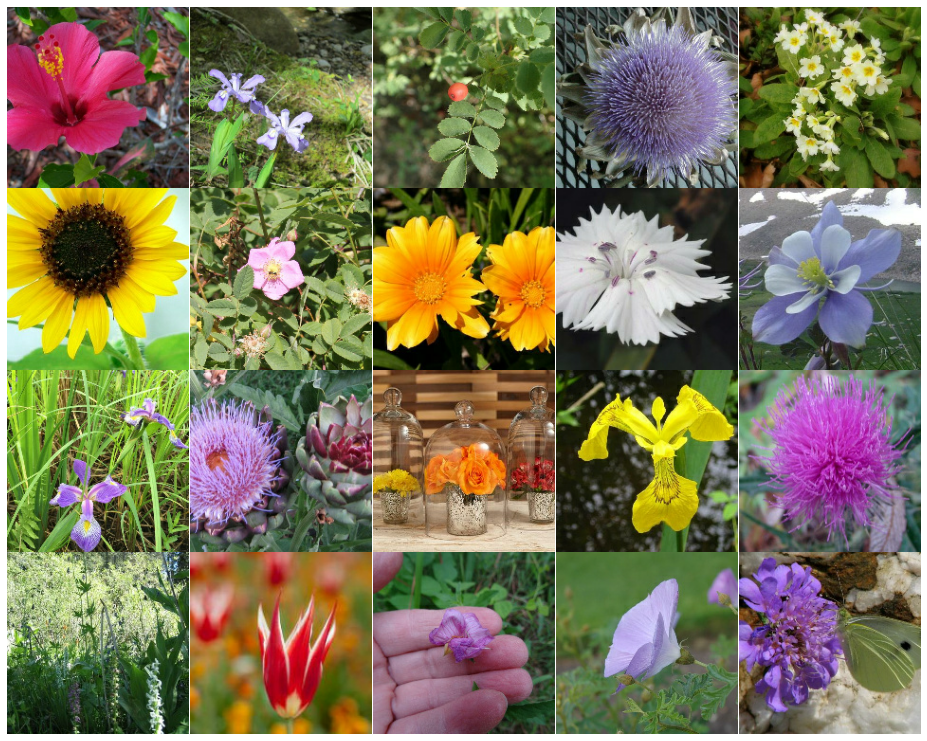

In [7]:
# peer at test data
test_dataset = get_test_dataset()
test_dataset = test_dataset.unbatch().batch(20)
test_batch = iter(test_dataset)
# run this cell again for next set of images
display_batch_of_images(next(test_batch))

In [8]:
NUM_TRAINING_IMAGES = count_data_items(TRAINING_FILENAMES)
NUM_VALIDATION_IMAGES = count_data_items(VALIDATION_FILENAMES)
NUM_TEST_IMAGES = count_data_items(TEST_FILENAMES)
STEPS_PER_EPOCH = NUM_TRAINING_IMAGES // BATCH_SIZE
print('Dataset: {} training images, {} validation images, {} unlabeled test images'.format(NUM_TRAINING_IMAGES, NUM_VALIDATION_IMAGES, NUM_TEST_IMAGES))

Dataset: 12753 training images, 3712 validation images, 7382 unlabeled test images


In [9]:
with strategy.scope():
    #pretrained_model = tf.keras.applications.DenseNet201(weights='imagenet', include_top=False ,input_shape=[*IMAGE_SIZE, 3])
    #pretrained_model = tf.keras.applications.Xception(weights='imagenet', include_top=False ,input_shape=[*IMAGE_SIZE, 3])
    pretrained_model = tf.keras.applications.VGG16(weights='imagenet', include_top=False ,input_shape=[*IMAGE_SIZE, 3])
    pretrained_model.trainable = False # False= transfer learning, True = fine tuning
    
    model = tf.keras.Sequential([
        pretrained_model,
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dense(len(CLASSES), activation='softmax')
    ])
    
    
model.compile(
    optimizer = 'adam',
    loss = 'sparse_categorical_crossentropy',
    metrics = ['sparse_categorical_accuracy']
)
   

In [10]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 6, 6, 512)         14714688  
_________________________________________________________________
global_average_pooling2d (Gl (None, 512)               0         
_________________________________________________________________
dense (Dense)                (None, 104)               53352     
Total params: 14,768,040
Trainable params: 53,352
Non-trainable params: 14,714,688
_________________________________________________________________


# Training

In [11]:
history = model.fit(get_training_dataset(), steps_per_epoch=STEPS_PER_EPOCH, epochs=EPOCHS, validation_data=get_validation_dataset())

Epoch 1/12
797/797 [==============================] - 38s 48ms/step - loss: 3.5408 - sparse_categorical_accuracy: 0.2086 - val_loss: 3.0439 - val_sparse_categorical_accuracy: 0.3238
Epoch 2/12
797/797 [==============================] - 38s 48ms/step - loss: 2.7594 - sparse_categorical_accuracy: 0.3639 - val_loss: 2.5801 - val_sparse_categorical_accuracy: 0.4071
Epoch 3/12
797/797 [==============================] - 38s 48ms/step - loss: 2.3764 - sparse_categorical_accuracy: 0.4510 - val_loss: 2.3141 - val_sparse_categorical_accuracy: 0.4744
Epoch 4/12
797/797 [==============================] - 39s 49ms/step - loss: 2.1322 - sparse_categorical_accuracy: 0.5053 - val_loss: 2.1199 - val_sparse_categorical_accuracy: 0.5132
Epoch 5/12
797/797 [==============================] - 39s 49ms/step - loss: 1.9542 - sparse_categorical_accuracy: 0.5417 - val_loss: 1.9864 - val_sparse_categorical_accuracy: 0.5418
Epoch 6/12
797/797 [==============================] - 38s 48ms/step - loss: 1.8241 - spars

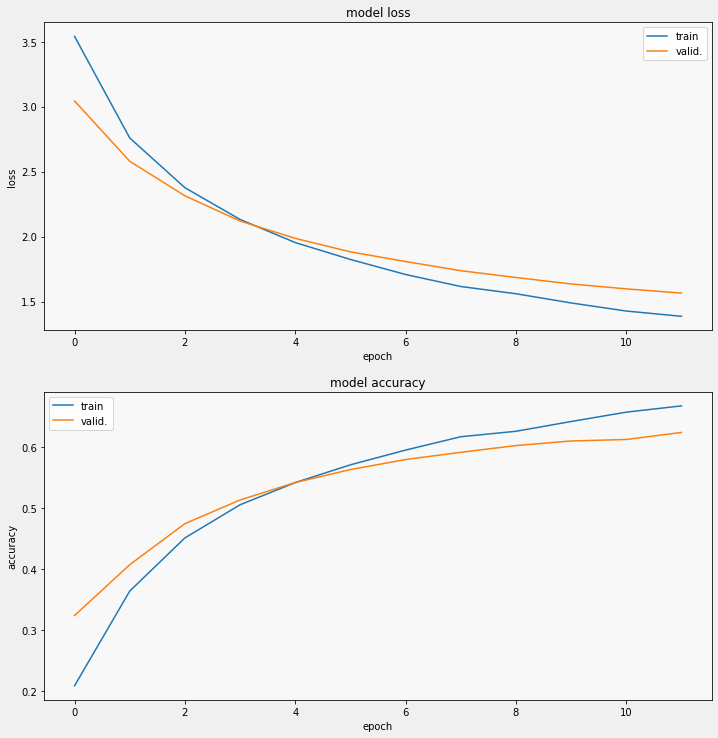

In [12]:
display_training_curves(history.history['loss'], history.history['val_loss'], 'loss', 211)
display_training_curves(history.history['sparse_categorical_accuracy'], history.history['val_sparse_categorical_accuracy'], 'accuracy', 212)

# Confusion matrix

In [15]:
cmdataset = get_validation_dataset(ordered=True) # since we are splitting the dataset and iterating separately on images and labels, order matters.
images_ds = cmdataset.map(lambda image, label: image)
labels_ds = cmdataset.map(lambda image, label: label).unbatch()
cm_correct_labels = next(iter(labels_ds.batch(NUM_VALIDATION_IMAGES))).numpy() # get everything as one batch
cm_probabilities = model.predict(images_ds)
cm_predictions = np.argmax(cm_probabilities, axis=-1)
print("Correct   labels: ", cm_correct_labels.shape, cm_correct_labels)
print("Predicted labels: ", cm_predictions.shape, cm_predictions)

Correct   labels:  (3712,) [75 69 82 ... 43 47 70]
Predicted labels:  (3712,) [103  69  82 ...  73  47  48]


/home/rajeev/virtual_env/tf_dev/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


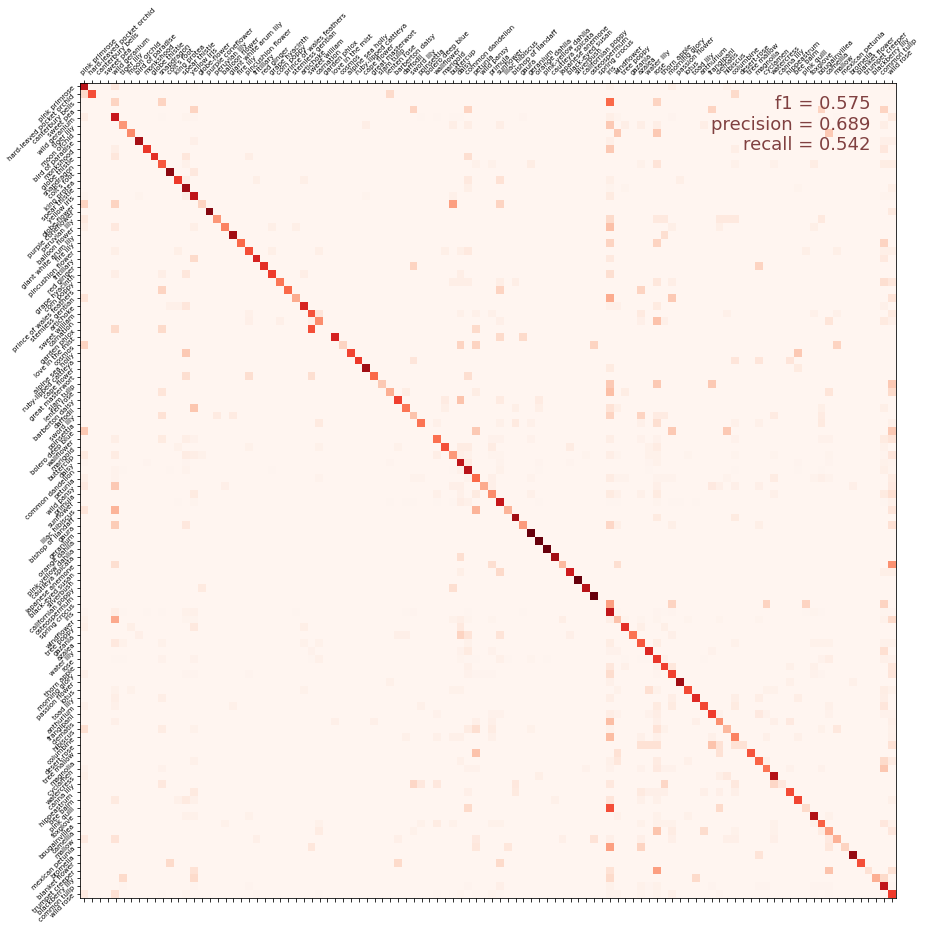

f1 score: 0.575, precision: 0.689, recall: 0.542


In [19]:
cmat = confusion_matrix(cm_correct_labels, cm_predictions, labels=range(len(CLASSES)))
score = f1_score(cm_correct_labels, cm_predictions, labels=range(len(CLASSES)), average='macro')
precision = precision_score(cm_correct_labels, cm_predictions, labels=range(len(CLASSES)), average='macro')
recall = recall_score(cm_correct_labels, cm_predictions, labels=range(len(CLASSES)), average='macro')
cmat = (cmat.T / cmat.sum(axis=1)).T # normalized
display_confusion_matrix(cmat, score, precision, recall)
print('f1 score: {:.3f}, precision: {:.3f}, recall: {:.3f}'.format(score, precision, recall))

# Predictions

In [20]:
test_ds = get_test_dataset(ordered=True) # since we are splitting the dataset and iterating separately on images and ids, order matters.

print('Computing predictions...')
test_images_ds = test_ds.map(lambda image, idnum: image)
probabilities = model.predict(test_images_ds)
predictions = np.argmax(probabilities, axis=-1)
print(predictions)

print('Generating submission.csv file...')
test_ids_ds = test_ds.map(lambda image, idnum: idnum).unbatch()
test_ids = next(iter(test_ids_ds.batch(NUM_TEST_IMAGES))).numpy().astype('U') # all in one batch
np.savetxt('submission.csv', np.rec.fromarrays([test_ids, predictions]), fmt=['%s', '%d'], delimiter=',', header='id,label', comments='')
!head submission.csv

Computing predictions...
[ 50  67 103 ...   7  50  74]
Generating submission.csv file...
id,label
aaa580243,50
b9e60ac3b,67
00e4f514e,103
52a88af32,28
aeb67eefb,4
8d808a07b,53
dfc9c6a23,103
59d1b6146,102
53cfc6586,49


# Visual validation

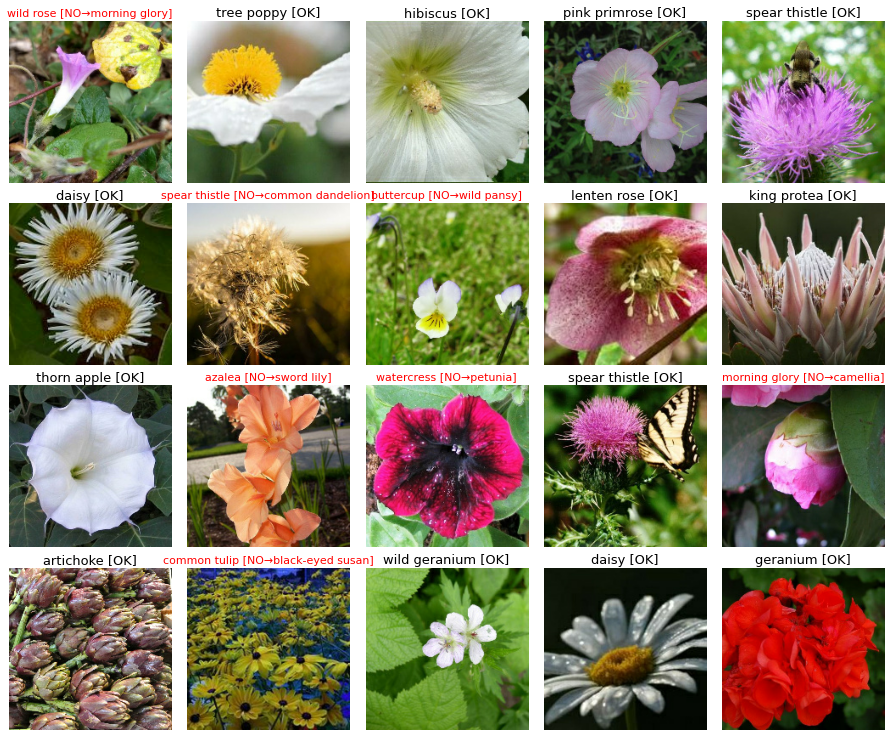

In [22]:
dataset = get_validation_dataset()
dataset = dataset.unbatch().batch(20)
batch = iter(dataset)
# run this cell again for next set of images
images, labels = next(batch)
probabilities = model.predict(images)
predictions = np.argmax(probabilities, axis=-1)
display_batch_of_images((images, labels), predictions)